In [1]:
# ==============================
# 1) Import thư viện
# ==============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    StratifiedKFold,
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score,
)
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

import sys, os
sys.path.append(os.path.abspath("../.."))
from src.preprocessing import preprocess_text_fin


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hung0\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\hung0\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
# ==============================
# 2) Cấu hình chung
# ==============================
DATA_PATH = "../../data/data.csv"     # thay bằng đường dẫn thực tế
TEXT_COL = "Sentence"
TARGET_COL = "Sentiment"

TEST_SIZE = 0.20
RANDOM_STATE = 42
N_SPLITS = 5

In [3]:
# ==============================
# 3) Load & tiền xử lý dữ liệu
# ==============================
df = pd.read_csv(DATA_PATH)
df["text_clean"] = df[TEXT_COL].apply(preprocess_text_fin)

X_train, X_test, y_train, y_test = train_test_split(
    df["text_clean"],
    df[TARGET_COL],
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=df[TARGET_COL],
)

In [6]:
# ==============================
# 4) Pipeline & GridSearchCV (SVM + probabilities)
# ==============================
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1, 2),
        max_df=0.95,
        min_df=5,
        max_features=10_000,
        sublinear_tf=True,
        norm="l2",
    )),
    ("clf", CalibratedClassifierCV(
        estimator=LinearSVC(
            class_weight="balanced", 
            max_iter=5000),
        cv= 5,
        method="sigmoid"
    )),
])

param_grid = {
    "clf__estimator__C": [0.01, 0.1, 0.5, 1.0, 2.0, 5.0],  
    "tfidf__ngram_range": [(1,1), (1,2)],    # (1,2) thường tốt với dữ liệu ngắn tài chính
    "tfidf__min_df": [2, 5],                # tránh min_df = 1 nếu nhiều từ hiếm
    "tfidf__max_df": [0.9, 0.95],            # loại bỏ từ quá phổ biến
    "tfidf__max_features": [5_000, 10_000],# với ~5.8k câu, 5k-10k thường đủ
    "tfidf__sublinear_tf": [True],                 # hay bật để giảm bias từ từ hay lặp
    "tfidf__norm": ["l2", None],                   # thường l2 tốt cho phân lớp
}

cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=1,
)

In [7]:
# ==============================
# 5) Train + Evaluate
# ==============================
gs.fit(X_train, y_train)
print("Best params:", gs.best_params_)
print("CV best f1_macro:", gs.best_score_)

best = gs.best_estimator_
y_pred = best.predict(X_test)

print("\n=== Test Accuracy:", accuracy_score(y_test, y_pred))
print("=== Test Macro-F1:", f1_score(y_test, y_pred, average="macro"))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best params: {'clf__estimator__C': 0.1, 'tfidf__max_df': 0.9, 'tfidf__max_features': 5000, 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 1), 'tfidf__norm': 'l2', 'tfidf__sublinear_tf': True}
CV best f1_macro: 0.5751555922084

=== Test Accuracy: 0.6869118905047049
=== Test Macro-F1: 0.5693598131844279

Classification Report:
               precision    recall  f1-score   support

    negative       0.40      0.19      0.26       172
     neutral       0.72      0.84      0.77       626
    positive       0.69      0.66      0.68       371

    accuracy                           0.69      1169
   macro avg       0.60      0.56      0.57      1169
weighted avg       0.66      0.69      0.67      1169



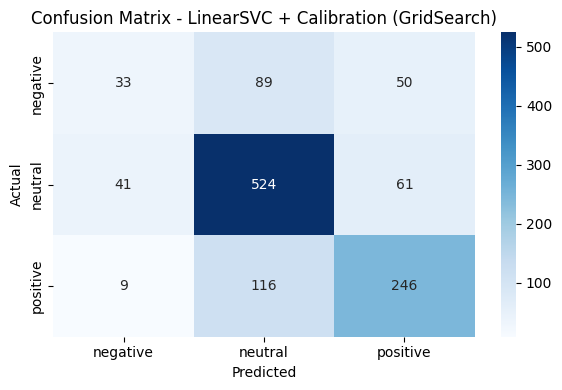

In [8]:
# ==============================
# 6) Confusion Matrix
# ==============================
clf_outer = best.named_steps["clf"]              # CalibratedClassifierCV
classes = clf_outer.classes_

cm = confusion_matrix(y_test, y_pred, labels=classes)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.title("Confusion Matrix - LinearSVC + Calibration (GridSearch)")
plt.tight_layout(); plt.show()

In [9]:
# ==============================
# 7) Top từ/ngữ quan trọng theo lớp (lấy trung bình coef_ qua các fold)
# ==============================
tfidf = best.named_steps["tfidf"]
feature_names = tfidf.get_feature_names_out()

# Mỗi fold calibration có 1 LinearSVC -> lấy trung bình hệ số để diễn giải
coefs_stack = np.stack([cc.estimator.coef_ for cc in clf_outer.calibrated_classifiers_], axis=0)
coefs_mean = coefs_stack.mean(axis=0)  # (n_classes, n_features)

TOPK = 10
for i, label in enumerate(classes):
    coefs = coefs_mean[i]
    top_pos_idx = np.argsort(coefs)[-TOPK:][::-1]
    print(f"\nTop words for class '{label}': {[feature_names[j] for j in top_pos_idx]}")




Top words for class 'negative': ['decreased', 'fall', 'lower', 'currency', 'fell', 'short', 'cut', 'hit', 'drop', 'dropped']

Top words for class 'neutral': ['will', 'approximately', 'value', 'includes', 'part', 'not', 'development', 'no', 'developed', 'headquartered']

Top words for class 'positive': ['rose', 'increased', 'increase', 'currency', 'buy', 'positive', 'grew', 'signed', 'awarded', 'long']


In [11]:
# ==============================
# 8) Hiển thị XÁC SUẤT
# ==============================
test_sentences = [
    "Dollar falls as traders bet on more rate cuts",
    "Central Europe's FX to get dollar boost, but forint likely to fall from highs",
    "Bulgaria sets price controls as euro transition nears",
    "To make economies work for everyone, we need to put a price on social impact",
    "European shares settle lower as investors gauge mixed earnings, EU-US trade progress",
    "What's in the EU's countermeasures to US tariffs?",
    "Syria is secretly reshaping its economy. The president’s brother is in charge.",
]

test_clean_list = [preprocess_text_fin(s) for s in test_sentences]

# Lấy classes từ step cuối trong pipeline
classes = best.named_steps["clf"].classes_

# Dự đoán nhãn
pred_labels = best.predict(test_clean_list)

# Dự đoán xác suất (nếu có)
pred_probas = None
pred_probas = best.predict_proba(test_clean_list)

TOPK = 3  # số lớp top-k muốn in
for i, (raw, clean, pred) in enumerate(zip(test_sentences, test_clean_list, pred_labels), start=1):
    print(f"\n[{i}] Chuỗi gốc: {raw}")
    print(f"    Đã làm sạch: {clean}")
    print(f"    Nhãn dự đoán: {pred}")

    if pred_probas is not None:
        probs = pred_probas[i-1]  # dùng chỉ số vòng lặp, tránh .index(raw)
        topk = min(TOPK, len(classes))
        top_idx = np.argsort(probs)[-topk:][::-1]
        print("    Top xác suất:")
        for j in top_idx:
            print(f"      - {classes[j]}: {probs[j]:.4f}")
    else:
        print("    (Model không có predict_proba — bật CalibratedClassifierCV để có xác suất.)")



[1] Chuỗi gốc: Dollar falls as traders bet on more rate cuts
    Đã làm sạch: dollar fall trader bet rate cut
    Nhãn dự đoán: negative
    Top xác suất:
      - negative: 0.6379
      - neutral: 0.3276
      - positive: 0.0344

[2] Chuỗi gốc: Central Europe's FX to get dollar boost, but forint likely to fall from highs
    Đã làm sạch: central europe fx dollar boost, forint likely fall high
    Nhãn dự đoán: neutral
    Top xác suất:
      - neutral: 0.5161
      - positive: 0.2619
      - negative: 0.2221

[3] Chuỗi gốc: Bulgaria sets price controls as euro transition nears
    Đã làm sạch: bulgaria set price control euro transition nears
    Nhãn dự đoán: neutral
    Top xác suất:
      - neutral: 0.8275
      - negative: 0.0923
      - positive: 0.0802

[4] Chuỗi gốc: To make economies work for everyone, we need to put a price on social impact
    Đã làm sạch: make economy work everyone, need put price social impact
    Nhãn dự đoán: neutral
    Top xác suất:
      - neutral: 0.7

In [12]:
import pickle

# Lưu pipeline đã train
with open("../../models/Super_Vector_Machine/SVM_model.pkl", "wb") as f:
    pickle.dump(best, f)

print("✅ Mô hình đã được lưu vào ../../models/Super_Vector_Machine/SVM_model.pkl")

✅ Mô hình đã được lưu vào ../../models/Super_Vector_Machine/SVM_model.pkl
